In [8]:
import copy
import math
import random
import socket
import time
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import nashpy as nash
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
from subruleset0 import SubRuleSet0
from subruleset1 import SubRuleSet1

In [3]:
device = torch.device('cuda')
lr = 1e-4
weight_decay = 1e-2
clip_param = 0.1
gamma = 0.98
batch_size = 256
train_step_m = 4
%config InlineBackend.figure_format='svg'
plt.rcParams['font.sans-serif'] = ['SimHei']

In [4]:
torch.set_default_device(device)

In [5]:
log = True

In [6]:
log = False

In [7]:
def get_critic():
    return nn.Sequential(
        nn.Linear(11, 64, device=device),
        nn.Tanh(),
        nn.Linear(64, 64, device=device),
        nn.Tanh(),
        nn.Linear(64, 1, device=device)
    )

In [8]:
class TrainBuffer:
    def __init__(self, size):
        self.i_list = []
        self.o_list = []
        self.act_list = []
        self.r_list = []
        self.done_list = []

        self.size = size
        self.mse = torch.nn.MSELoss()

    def clear(self):
        self.i_list.clear()
        self.o_list.clear()
        self.act_list.clear()
        self.r_list.clear()
        self.done_list.clear()
    
    def full(self):
        return len(self.i_list) == self.size

    def add(self, i, o, act, r, done):
        self.i_list.append(i.detach())
        self.o_list.append(o.detach())
        self.act_list.append([act])
        self.r_list.append(r)
        self.done_list.append(done)

    def train(self, actor, critic, opt_a, opt_c, mse_his):
        rewards = []
        with torch.no_grad():
            dis_reward = float(critic(self.i_list[-1]))
        for r, done in zip(reversed(self.r_list), reversed(self.done_list)):
            if done:
                dis_reward = 0.0
            dis_reward = r + gamma * dis_reward
            rewards.append([dis_reward])
        rewards = torch.tensor(list(reversed(rewards)), device=device)
        i = torch.cat(self.i_list)
        act = torch.tensor(self.act_list, device=device, dtype=torch.int64)
        pa_old = torch.tensor([[prob[action]] for prob, action in zip(self.o_list, self.act_list)], device=device)
        for t in range(train_step_m):
            prob_new = actor.forward(i).mT
            r = prob_new.gather(1, act) / pa_old
            a_ = None
            with torch.no_grad():
                a_ = rewards - critic(i)

            l_clip = -torch.min(r * a_, torch.clamp(r, 1 - clip_param, 1 + clip_param) * a_)
            opt_a.zero_grad()
            l_clip.mean().backward()
            opt_a.step()

            l_bl = self.mse(rewards, critic(i))
            if t == 0:
                mse_his.append(float(l_bl))
            opt_c.zero_grad()
            l_bl.mean().backward()
            opt_c.step()


In [9]:
class RandomSubRuleSet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 64, device=device),
            nn.Tanh(),
            nn.Linear(64, 64, device=device),
            nn.Tanh(),
            nn.Linear(64, 9, device=device),
            nn.Softmax(dim=1)
        )
        self.ans = None

    def hook_into(self, sub_ruleset: SubRuleSet1):
        sub_ruleset.paras = self.parameters()
        sub_ruleset.hooked = lambda x:self.forward(x).mT
        # conditions = []
        # conditions.append(lambda x:self.forward(x.state)[:,0])
        # for i in range(1, 8):
        #     conditions.append(lambda x:self.ans[:,i])
        # sub_ruleset.conditions = conditions

    def forward(self, x):
        self.ans = self.net.forward(x)
        return self.ans

In [10]:
class Agent:
    def __init__(self, port: int, i: dict[str, any], o: dict[str, any], c: dict[str, any], pre_process: SubRuleSet0, rule_set: SubRuleSet1, recycled_link=None):
        # todo
        if recycled_link is None:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.bind(("localhost", port))
            s.listen()
            self.link, _ = s.accept()
        else:
            self.link = recycled_link
        self.input = i
        self.output = o
        self.cache = c
        self.pre_process = pre_process
        self.rule_set = rule_set
        self.round = 0
        self.opt = optim.AdamW(rule_set.paras, lr=lr, amsgrad=True, weight_decay=weight_decay)
        self.critic = get_critic()
        self.opt_critic = optim.AdamW(self.critic.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
        self.his = []
        self.final_reward = []
        self.critic_mse = []
        self.train_data = TrainBuffer(batch_size)

        self.reward_pre = 0
        self.act_pre = 0
        self.prob_pre = None

        self.end = False
        self.init_input = {}
        self.clear_state()
        self.recv_input()
        self.init_input = copy.deepcopy(self.input)

        self.training_mode = True
        self.branch_his = {}
        self.collected_act = {}

    def cal_reward(self):
        if not self.input["carInfo"]:
            return 0
        reward = 0
        s1_dead, s2_dead = True, True
        for info in self.input["carInfo"]:
            dl = info["baseInfo"]["damageLevel"]
            side = 1 if info["baseInfo"]["side"] == 2 else -1
            no_man_car = (side == 1) and info["baseInfo"]["id"] in {17, 18, 21, 22}
            if dl == 1:
                if side == 1:
                    reward += 0 if no_man_car else 1
                else:
                    reward -= 1
            elif dl == 2 or dl == 3:
                if side == 1:
                    reward += 1 if no_man_car else 3
                else:
                    reward -= 3
            elif side == 1:
                s2_dead = False
            else:
                s1_dead = False
        if s1_dead or s2_dead or self.round >= 5000:
            self.end = True
            self.final_reward.append(reward)
            if s1_dead: reward -= 10 + self.cache["distance"] / 500 + (5000 - self.round) / 500
            elif s2_dead: reward += 10 + self.cache["distance"] / 500 + (5000 - self.round) / 500
            else: reward -= 5 + self.cache["distance"] / 500
            
        tmp = reward - self.reward_pre
        self.reward_pre = reward
        # if self.gamma_reward != 0:
        #     print(f'reward: {self.gamma_reward}')
        return tmp

    def clear_state(self):
        self.reward_pre = 0
        self.end = False
        self.input.clear()
        for k, v in self.init_input.items():
            self.input[k] = copy.deepcopy(v)
        self.cache.clear()
        self.output.clear()
        
        self.reward_pre = 0
        self.act_pre = 0
        self.prob_pre = None
        self.round = 0

        self.output["targetDir"] = {"x":0, "y":0, "z":0}
        self.output["targetVel"] = 0
        self.output["enableFire"] = False
        self.output["formationID"] = 0
        self.output["fireTarget"] = 0
        
        self.cache["combatStage"] = 0
        self.cache["side_distance"] = 0

    def send_output(self):
        if self.end:
            if log:
                print('restart')
            self.send('<c><restart><uint32_t>1</uint32_t></restart></c>')
            self.clear_state()
            return
        px, py, pz = self.output["targetDir"]["x"], self.output["targetDir"]["y"], self.output["targetDir"]["z"]
        targetDir = f'<targetDir><c><x><double>{px}</double></x><y><double>{py}</double></y><z><double>{pz}</double></z></c></targetDir>'
        targetVel = f'<targetVel><double>{self.output["targetVel"]}</double></targetVel>'
        enableFire = f'<enableFire><uint32_t>{1 if self.output["enableFire"] else 0}</uint32_t></enableFire>'
        formationID = f'<formationID><uint64_t>{int(self.output["formationID"])}</uint64_t></formationID>'
        fireTarget = f'<fireTarget><uint64_t>{int(self.output["fireTarget"])}</uint64_t></fireTarget>'
        s = '<c>' + targetDir + targetVel + enableFire + formationID + fireTarget + '</c>'
        self.send(s)

    def recv_input(self):
        s = self.recv()
        tmp = []
        for input in eval(s):
            for k, v in input.items():
                if k == 'carInfo':
                    tmp.append(v)
                else:
                    self.input[k] = v
        self.input['carInfo'] = tmp

    def send(self, s: str):
        self.round += 1
        if log:
            print(f'send: {s}')
        self.link.send(s.encode() + b'\n')

    def recv(self)->str:
        """will return string ends with '\\n'"""
        s: bytes = b''
        while not s.endswith(b'\n'):
            s = s + self.link.recv(1024)
        # if log:
        #     print(f'received: {s.decode()}')
        return s.decode()

    def tick(self):
        # TODO:
        self.pre_process.temp_cached_vars = self.cache
        self.pre_process.actions[0](self.pre_process)
        
        ruleset = self.rule_set
        ruleset.cal_state()
        prob = ruleset.forward()
        self.prob_pre = prob
        act = np.random.choice(prob.shape[0], p=prob.detach().reshape((9,)).cpu().numpy())
        self.act_pre = act
        for need_collect in self.collected_act:
            state_id, and_id = self.collected_act[need_collect]
            if need_collect not in self.branch_his:
                self.branch_his[need_collect] = ([], [])
            if act > need_collect and float(ruleset.state[:,and_id]) > 0.5:
                self.branch_his[need_collect][1].append(float(ruleset.state[:,state_id]))
            elif act == need_collect: # definitely satisfied and no need to test: and float(ruleset.state[:,and_id]) > 0.5:
                self.branch_his[need_collect][0].append(float(ruleset.state[:,state_id]))
        if log:
            print(f'choose action {act}')
        ruleset.cached_vars = self.cache
        ruleset.temp_cached_vars = self.cache
        ruleset.actions[act](ruleset)

    def train_step(self):
        if self.prob_pre is None:
            return
        r = self.cal_reward()
        if not self.training_mode:
            return
        self.his.append(r)
        i = self.rule_set.state
        o = self.prob_pre
        act = self.act_pre
        self.train_data.add(i, o, act, r, self.end)
        if self.train_data.full():
            self.train_data.train(self.rule_set, self.critic, self.opt, self.opt_critic, self.critic_mse)
            self.train_data.clear()
        # loss = -r * torch.log(o[act])
        # self.opt.zero_grad()
        # loss.backward()
        # self.opt.step()

In [11]:
def record_his(a: Agent, file_path):
    with open(file_path, 'w') as f:
        f.write(str({
            'his':a.his,
            'mse':a.critic_mse,
            'rew':a.final_reward,
        }))

def load_his(a: Agent, file_path):
    with open(file_path, 'r') as f:
        data = eval(f.read())
        a.his = data['his']
        a.critic_mse = data['mse']
        a.final_reward = data['rew']

In [12]:
def train(a: Agent, total_iters, enable_log=True):
    for cnt in range(total_iters):
        # a.send_output()
        # a.recv_input()
        if cnt % 10 == 0:
            a.send_output()
            a.recv_input()
            a.train_step()
            a.tick()
            if cnt % 1000 == 0 and enable_log:
                print(f'finished: {cnt / total_iters * 100}%')
            if cnt % 100000 == 0:
                with open('history.txt', 'w') as f:
                    f.write(str(a.rule_set.paras))
                    f.write('\n')
                    f.write(str(a.his))
                    f.write('\n')
        else:
            a.send('')
            a.recv_input()

In [13]:
i, o, c = {}, {}, {}
s1, s2 = SubRuleSet0(i, o, c), SubRuleSet1(i, o, c)

In [14]:
# replace = RandomSubRuleSet1()
# replace.hook_into(s2)

In [15]:
a = Agent(40023, i, o, c, s1, s2)

In [16]:
train(a, 200000)

finished: 0.0%
finished: 0.5%
finished: 1.0%
finished: 1.5%
finished: 2.0%
finished: 2.5%
finished: 3.0%
finished: 3.5000000000000004%
finished: 4.0%
finished: 4.5%
finished: 5.0%


In [17]:
# i, o, c = {}, {}, {}
# s1, s2 = SubRuleSet0(i, o, c), SubRuleSet1(i, o, c)
# a = Agent(40023, i, o, c, s1, s2)

# for id in range(5):
#     replace = RandomSubRuleSet1()
#     replace.hook_into(s2)
#     a.end = True
#     a.his.clear()
#     a.critic_mse.clear()
#     a.final_reward.clear()
#     # 600000
#     train(a, 600000, False)
#     record_his(a, f'r{id}')
#     print("need restart!")

In [22]:
def get_bound(l1, l2):
    # small, big
    if sum(l1)/len(l1) > sum(l2)/len(l2):
        l1, l2 = l2, l1
    if (max_1 := max(l1)) < (min_2 := min(l2)):
        return (max_1 + min_2) / 2
    def eval_f1(bound):
        tp = sum(1 for i in l1 if i < bound)
        fn = len(l1) - tp
        tn = sum(1 for i in l2 if i >= bound)
        fp = len(l2) - tn
        if tp + fp == 0 or tp + fn == 0:
            return -math.inf
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        return 2 / (1/p + 1/r)
    max_f1, bound = -math.inf, 0
    l = list(set(l1) | set(l2))
    for mid in l:
        if (v := eval_f1(mid)) > max_f1:
            max_f1, bound = v, mid
    return bound

In [19]:
# {act_id} : {input_id, and_condition_id}
a.collected_act = {2:(2, 3), 4:(5, 6), 6:(8, 9)}
a.end = True
a.training_mode = False
train(a, 100000)

finished: 0.0%
finished: 1.0%
finished: 2.0%
finished: 3.0%
finished: 4.0%
finished: 5.0%
finished: 6.0%
finished: 7.000000000000001%
finished: 8.0%
finished: 9.0%
finished: 10.0%
finished: 11.0%
finished: 12.0%
finished: 13.0%
finished: 14.000000000000002%
finished: 15.0%
finished: 16.0%
finished: 17.0%
finished: 18.0%
finished: 19.0%
finished: 20.0%
finished: 21.0%
finished: 22.0%
finished: 23.0%
finished: 24.0%
finished: 25.0%
finished: 26.0%
finished: 27.0%
finished: 28.000000000000004%
finished: 28.999999999999996%
finished: 30.0%
finished: 31.0%
finished: 32.0%
finished: 33.0%
finished: 34.0%
finished: 35.0%
finished: 36.0%
finished: 37.0%
finished: 38.0%
finished: 39.0%
finished: 40.0%
finished: 41.0%
finished: 42.0%
finished: 43.0%
finished: 44.0%
finished: 45.0%
finished: 46.0%
finished: 47.0%
finished: 48.0%
finished: 49.0%
finished: 50.0%
finished: 51.0%
finished: 52.0%
finished: 53.0%
finished: 54.0%
finished: 55.00000000000001%
finished: 56.00000000000001%
finished: 56.999

In [23]:
for k, v in a.collected_act.items():
    print(v[0], get_bound(a.branch_his[k][0], a.branch_his[k][1]))

2 -45.12753677368164
5 -11.408984184265137
8 -873.3961181640625


In [17]:
def cov(l: list[float], func, range_: int, step_: int | None=None):
    if step_ is None:step_ = range_
    return [func(l[i*step_:i*step_+range_]) for i in range((len(l) + 1 - range_) // step_)]

def mean_plot(l: list[float], range_: int, step_: int | None=None):
    if step_ is None:step_ = range_
    mean = lambda x:sum(x)/len(x)
    plt.plot(cov(l, mean, range_, step_))

def sigma(l):
    avg = sum(l) / len(l)
    return math.sqrt(sum((i - avg)**2 for i in l)/len(l))

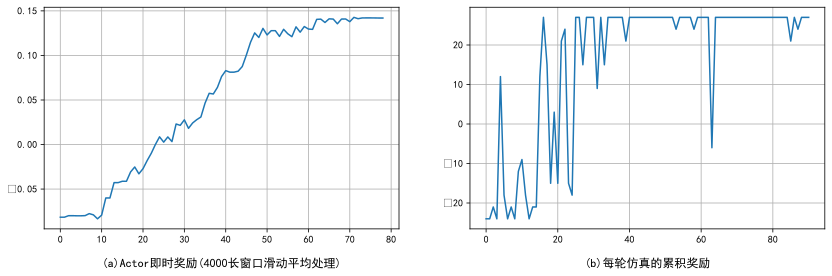

In [25]:
plt.rcParams['figure.figsize'] = (14,4)
rate = 0.05

plt.subplot(1, 2, 1)
plt.title('(a)Actor即时奖励(4000长窗口滑动平均处理)', y=-0.2)
plt.plot(cov(a.his, lambda x:sum(x)/len(x), 4000, 200))
plt.grid()
plt.subplot(1, 2, 2)
plt.title('(b)每轮仿真的累积奖励', y=-0.2)
mean_plot(a.final_reward, 1, 1)
plt.grid()

In [20]:
record_his(a, '__')

In [52]:
load_his(a, 'random0')

In [ ]:
class Env:
    def __init__(self, port1, port2):
        self.agent1 = Agent(port1)
        self.agent2 = Agent(port2)
        self.agent1.recv_input()
        self.agent2.recv_input()

    def restart(self):
        self.agent1.send('<c><restart><bool>1</bool></restart></c>')
        self.agent2.send('<c><restart><bool>1</bool></restart></c>')
        self.agent1.recv_input()
        self.agent2.recv_input()

    def start(self):
        self.step()

    def step(self):
        self.agent1.send_output()
        self.agent2.send_output()
        self.agent1.recv_input()
        self.agent2.recv_input()
        self.agent1.tick()
        self.agent2.tick()
        # TODO: choose action

In [3]:
a = 1.1
b = 1.2
c = a * b
t1 = time.time()
for _ in range(100000):
    c = c + a * b
t2 = time.time()
t2 - t1

0.010184049606323242

In [4]:
a = torch.tensor(1.1, device=device, requires_grad=True)
b = torch.tensor(1.2, device=device, requires_grad=True)
c = a * b
t1 = time.time()
for _ in range(100000):
    c = c + a * b
t2 = time.time()
c.backward()
t3 = time.time()
t2 - t1, t3 - t2

(0.6119277477264404, 0.8815679550170898)

In [32]:
a = torch.tensor([[1.1]], device=device, requires_grad=True)
b = torch.tensor([[1.2]], device=device, requires_grad=True)
c = torch.concat((a, b))
d = torch.tensor([[1., 1.]], device=device).matmul(c)
d.backward()
a.grad

tensor([[1.]])

In [3]:
class SimpleEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.times = 0
        return (0, 0)
    
    def step(self, action):
        a_a, a_b = action
        self.times += 1
        done = self.times == 10
        if a_a == a_b:return (0, 0), (0, 0), done, ''
        if (a_a + 1) % 3 == a_b:return (0, 0), (1, -1), done, ''
        return (0, 0), (-1, 1), done, ''

In [4]:
class MixAgent(torch.nn.Module):
    def __init__(self, agents, prob) -> None:
        super().__init__()
        self.agents = agents
        self.prob = prob
        self.used: torch.nn.Module = None

    def pick(self) -> None:
        self.used = random.choices(self.agents, k=1, weights=self.prob)[0]

    def forward(self, x):
        return self.used.forward(x)

In [5]:
def get_agent():
    return nn.Sequential(
        nn.Linear(1, 4, device=device),
        nn.ReLU(),
        nn.Linear(4, 3, device=device),
        nn.Softmax(),
    )

In [6]:
def get_advantage(a1, a2, env, iters):
    r = 0
    for _ in range(iters):
        s1, s2 = env.reset()
        done = False
        while not done:
            act1, act2 = 0, 0
            with torch.no_grad():
                p1 = a1(torch.Tensor([float(s1)])).numpy()
                act1 = np.random.choice(p1.shape[0], p=p1)
                p2 = a2(torch.Tensor([float(s2)])).numpy()
                act2 = np.random.choice(p2.shape[0], p=p2)
            next_state, reward, done, _ = env.step((act1, act2))
            r += reward[0]
            s1, s2 = next_state
    return r / iters


In [7]:
class FakeAgent(nn.Module):
    def forward(self, x):
        return torch.Tensor([1/3, 1/3, 1/3])

In [8]:
get_advantage(FakeAgent(), FakeAgent(), SimpleEnv(), 1)

-1.0

In [9]:
class PSRO_2side:
    def __init__(self):
        self.agents = [[], []]
        self.matrix = []
        self.prob = [None, None]

    def get_agent(self):
        return [MixAgent(a, p) for a, p in zip(self.agents, self.prob)]
    
    def add_agent(self, a1, a2, func):
        l = len(self.matrix)
        self.agents[0].append(a1)
        self.agents[1].append(a2)
        self.matrix = [i+[func(self.agents[0][ind], a2)] for ind, i in enumerate(self.matrix)]
        self.matrix.append([func(a1, self.agents[1][i]) for i in range(l+1)])
        self.solve_meta()

    def solve_meta(self):
        game = nash.Game(np.array(self.matrix))
        ans = next(game.support_enumeration(), None)
        if ans is None:
            ans = next(game.vertex_enumeration(), None)
        self.prob = list(map(lambda x:x.tolist(), ans))

In [10]:
def train_step(act_freeze, act_target, opt, env, iters):
    his = []
    for _ in range(iters):
        s1, s2 = env.reset()
        done = False
        r = 0
        target = 0
        act_freeze.pick()
        while not done:
            act1, act2 = 0, 0
            with torch.no_grad():
                p1 = act_freeze(torch.Tensor([float(s1)])).numpy()
                act1 = np.random.choice(p1.shape[0], p=p1)
            p2 = act_target(torch.Tensor([float(s2)]))
            act2 = np.random.choice(p2.shape[0], p=p2.detach().numpy())
            # print(p1, p2, act1, act2)
            next_state, reward, done, info = env.step((act1, act2))
            r += reward[1]
            target += -reward[1] * p2[act2]
            s1, s2 = next_state
        opt.zero_grad()
        target.backward()
        opt.step()
        his.append(r)
    return his

def policy_grad_train(env, psro: PSRO_2side, iters: int):
    a1, a2 = get_agent(), get_agent()
    opt1 = optim.AdamW(a1.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    opt2 = optim.AdamW(a2.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    a1_, a2_ = psro.get_agent()
    size = len(psro.agents[0]) + 1
    his = train_step(a2_, a1, opt1, env, iters * size), train_step(a1_, a2, opt2, env, iters * size)
    psro.add_agent(a1, a2, lambda a1, a2: get_advantage(a1, a2, env, iters))
    return his

In [11]:
env, psro = SimpleEnv(), PSRO_2side()
psro.add_agent(get_agent(), get_agent(), lambda a1, a2: get_advantage(a1, a2, env, iters))

d:\Miniconda3\envs\torch-cpu\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [12]:
# _ = policy_grad_train(env, psro, iters)

In [13]:
for _ in range(10):
    policy_grad_train(env, psro, iters)
    print(sum(i(torch.Tensor([0.])) * j for i, j in zip(psro.agents[0], psro.prob[0])),
        sum(i(torch.Tensor([0.])) * j for i, j in zip(psro.agents[1], psro.prob[1])))

d:\Miniconda3\envs\torch-cpu\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([2.1996e-05, 3.5317e-06, 9.9997e-01], grad_fn=<AddBackward0>) tensor([0.5388, 0.2401, 0.2211], grad_fn=<AddBackward0>)


d:\Miniconda3\envs\torch-cpu\Lib\site-packages\nashpy\algorithms\support_enumeration.py:259: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


tensor([0.2852, 0.3761, 0.3387], grad_fn=<AddBackward0>) tensor([4.7664e-01, 5.2336e-01, 7.2774e-06], grad_fn=<AddBackward0>)
tensor([5.6806e-01, 4.4243e-05, 4.3190e-01], grad_fn=<AddBackward0>) tensor([0.4699, 0.3372, 0.1929], grad_fn=<AddBackward0>)
tensor([0.3315, 0.3304, 0.3381], grad_fn=<AddBackward0>) tensor([0.3328, 0.3333, 0.3339], grad_fn=<AddBackward0>)
tensor([0.3334, 0.3333, 0.3333], grad_fn=<AddBackward0>) tensor([0.3332, 0.3333, 0.3334], grad_fn=<AddBackward0>)
tensor([0.3334, 0.3333, 0.3332], grad_fn=<AddBackward0>) tensor([0.3326, 0.3336, 0.3339], grad_fn=<AddBackward0>)
tensor([0.3331, 0.3337, 0.3332], grad_fn=<AddBackward0>) tensor([0.3320, 0.3335, 0.3345], grad_fn=<AddBackward0>)
tensor([0.3336, 0.3328, 0.3336], grad_fn=<AddBackward0>) tensor([0.3331, 0.3333, 0.3336], grad_fn=<AddBackward0>)
tensor([0.3336, 0.3328, 0.3336], grad_fn=<AddBackward0>) tensor([0.3331, 0.3333, 0.3336], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

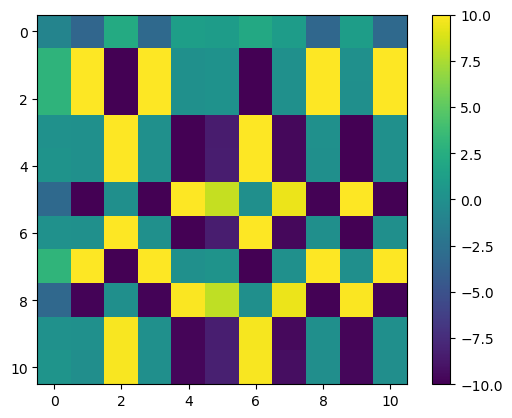

In [26]:
plt.imshow(psro.matrix)
plt.colorbar()

In [24]:
psro.matrix

[[-0.982,
  -3.424,
  2.226,
  -3.176,
  1.174,
  1.09,
  2.088,
  1.088,
  -3.282,
  1.148,
  -3.166],
 [2.998, 10.0, -10.0, 9.96, 0.0, 0.2, -10.0, 0.07, 9.996, 0.0, 9.998],
 [3.024,
  9.994,
  -9.996,
  9.978,
  0.0,
  0.206,
  -9.986,
  0.074,
  9.978,
  -0.002,
  9.992],
 [0.096, 0.0, 10.0, 0.01, -10.0, -8.51, 9.998, -9.59, 0.0, -9.994, 0.002],
 [0.302, 0.0, 10.0, 0.006, -10.0, -8.426, 10.0, -9.582, -0.002, -9.996, 0.002],
 [-3.168,
  -9.926,
  -0.004,
  -9.928,
  9.924,
  8.222,
  -0.014,
  9.414,
  -9.916,
  9.924,
  -9.95],
 [0.128,
  0.01,
  9.996,
  0.014,
  -9.988,
  -8.39,
  9.994,
  -9.58,
  -0.004,
  -9.98,
  -0.002],
 [3.05, 9.998, -9.998, 9.958, 0.0, 0.242, -9.994, 0.056, 9.994, -0.01, 9.992],
 [-3.228,
  -9.824,
  -0.008,
  -9.806,
  9.852,
  8.104,
  -0.008,
  9.378,
  -9.852,
  9.862,
  -9.828],
 [0.144, 0.0, 9.8, 0.02, -9.752, -8.346, 9.76, -9.47, -0.012, -9.754, -0.004],
 [0.35,
  -0.124,
  9.804,
  -0.062,
  -9.682,
  -8.238,
  9.782,
  -9.228,
  -0.124,
  -9.672,


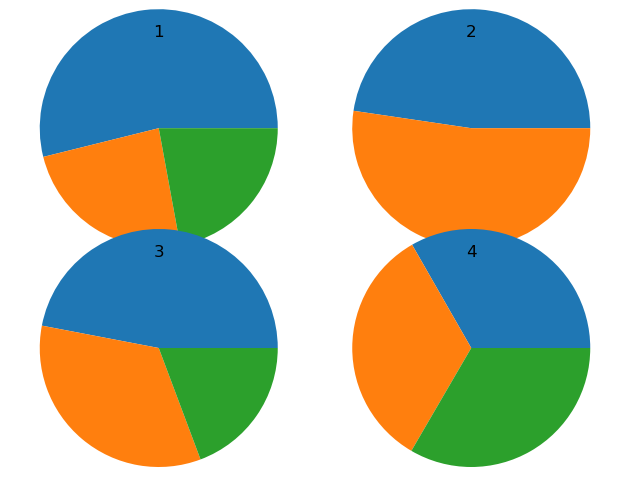

In [29]:
plt.subplot(2, 2, 1)
plt.pie([0.5388, 0.2401, 0.2211])
plt.ylim(0, 0.7)
plt.title('1')
plt.subplot(2, 2, 2)
plt.pie([4.7664e-01, 5.2336e-01, 7.2774e-06])
plt.ylim(0, 0.7)
plt.title('2')
plt.subplot(2, 2, 3)
plt.pie([0.4699, 0.3372, 0.1929])
plt.ylim(0, 0.7)
plt.title('3')
plt.subplot(2, 2, 4)
plt.pie([0.3328, 0.3333, 0.3339])
plt.ylim(0, 0.7)
plt.title('4')
plt.tight_layout()

In [15]:
psro.matrix, psro.prob

([[-0.982,
   -3.424,
   2.226,
   -3.176,
   1.174,
   1.09,
   2.088,
   1.088,
   -3.282,
   1.148,
   -3.166],
  [2.998, 10.0, -10.0, 9.96, 0.0, 0.2, -10.0, 0.07, 9.996, 0.0, 9.998],
  [3.024,
   9.994,
   -9.996,
   9.978,
   0.0,
   0.206,
   -9.986,
   0.074,
   9.978,
   -0.002,
   9.992],
  [0.096, 0.0, 10.0, 0.01, -10.0, -8.51, 9.998, -9.59, 0.0, -9.994, 0.002],
  [0.302,
   0.0,
   10.0,
   0.006,
   -10.0,
   -8.426,
   10.0,
   -9.582,
   -0.002,
   -9.996,
   0.002],
  [-3.168,
   -9.926,
   -0.004,
   -9.928,
   9.924,
   8.222,
   -0.014,
   9.414,
   -9.916,
   9.924,
   -9.95],
  [0.128,
   0.01,
   9.996,
   0.014,
   -9.988,
   -8.39,
   9.994,
   -9.58,
   -0.004,
   -9.98,
   -0.002],
  [3.05, 9.998, -9.998, 9.958, 0.0, 0.242, -9.994, 0.056, 9.994, -0.01, 9.992],
  [-3.228,
   -9.824,
   -0.008,
   -9.806,
   9.852,
   8.104,
   -0.008,
   9.378,
   -9.852,
   9.862,
   -9.828],
  [0.144, 0.0, 9.8, 0.02, -9.752, -8.346, 9.76, -9.47, -0.012, -9.754, -0.004],
  [0.3